<h1>IQPEmbedding</h1>

In [1]:
# Importing modules
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers, IQPEmbedding
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt



In [2]:
# Setting parameters

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/IQPEmbedding" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
# Loading of the MNIST dataset

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)



In [4]:
"""
We initialize a PennyLane default.qubit device, simulating a system of 4

qubits. The associated qnode represents the quantum circuit consisting of:

1) an embedding layer of local Ry rotations (with angles scaled by a factor of π);
2) a random circuit of n_layers;
3) a final measurement in the computational basis, estimating 4 expectation values.
"""

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(features,repeat):
    # Encoding of 4 classical input values
    IQPEmbedding(features, wires =range(4), n_repeats=repeat)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
"""
The next function defines the convolution scheme:

1)the image is divided into squares of 2×2 pixels;
2)each square is processed by the quantum circuit;
3)the 4 expectation values are mapped into 4 different channels of a single output pixel.
"""

def quanv(image,repeat):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ], repeat
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out



In [6]:
def Process(repeat):
    if PREPROCESS == True:
        q_train_images = []
        print("Quantum pre-processing of train images:")
        for idx, img in enumerate(train_images):
            print("{}/{}        ".format(idx + 1, n_train), end="\r")
            q_train_images.append(quanv(img,repeat))
        q_train_images = np.asarray(q_train_images)

        q_test_images = []
        print("\nQuantum pre-processing of test images:")
        for idx, img in enumerate(test_images):
            print("{}/{}        ".format(idx + 1, n_test), end="\r")
            q_test_images.append(quanv(img,repeat))
        q_test_images = np.asarray(q_test_images)

        # Save pre-processed images
        np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
        np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


    # Load pre-processed images
    q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

    return q_train_images, q_test_images

In [7]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [8]:
def Train_model(epochs):
    q_model = MyModel()

    q_history = q_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )

    c_model = MyModel()

    c_history = c_model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )
    return q_history, c_history
    

<h1> Repeats </h1>

<h2> Repeat = 1 </h2>

In [9]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


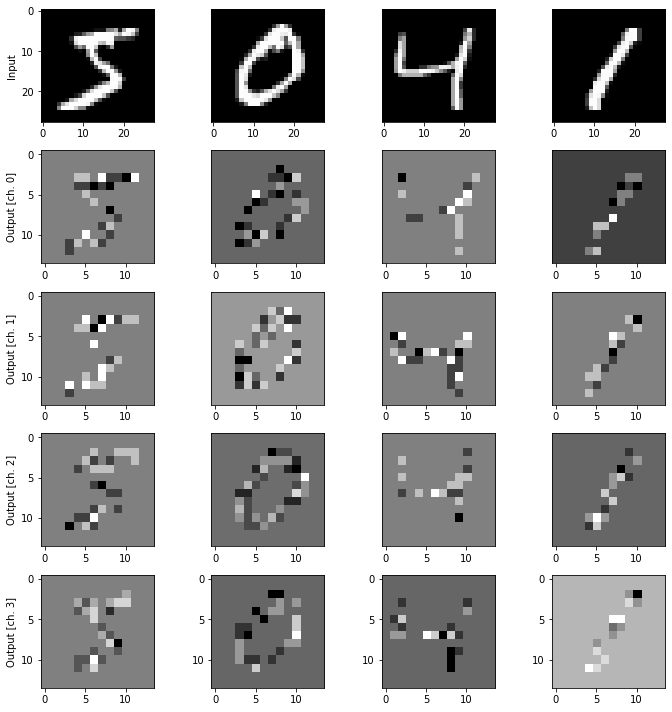

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
q_history, c_history = Train_model(100)

Epoch 1/10
13/13 - 0s - loss: 2.3028 - accuracy: 0.0400 - val_loss: 2.3020 - val_accuracy: 0.1333
Epoch 2/10
13/13 - 0s - loss: 2.3018 - accuracy: 0.1400 - val_loss: 2.3020 - val_accuracy: 0.1333
Epoch 3/10
13/13 - 0s - loss: 2.3012 - accuracy: 0.1400 - val_loss: 2.3021 - val_accuracy: 0.1333
Epoch 4/10
13/13 - 0s - loss: 2.3007 - accuracy: 0.1400 - val_loss: 2.3019 - val_accuracy: 0.1333
Epoch 5/10
13/13 - 0s - loss: 2.3000 - accuracy: 0.1400 - val_loss: 2.3015 - val_accuracy: 0.1333
Epoch 6/10
13/13 - 0s - loss: 2.2995 - accuracy: 0.1400 - val_loss: 2.3015 - val_accuracy: 0.1333
Epoch 7/10
13/13 - 0s - loss: 2.2989 - accuracy: 0.1400 - val_loss: 2.3014 - val_accuracy: 0.1333
Epoch 8/10
13/13 - 0s - loss: 2.2985 - accuracy: 0.1400 - val_loss: 2.3012 - val_accuracy: 0.1333
Epoch 9/10
13/13 - 0s - loss: 2.2979 - accuracy: 0.0800 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 10/10
13/13 - 0s - loss: 2.2973 - accuracy: 0.1400 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 1/10
13/13 - 

Epoch 5/10
13/13 - 0s - loss: 2.3000 - accuracy: 0.1400 - val_loss: 2.3015 - val_accuracy: 0.1333
Epoch 6/10
13/13 - 0s - loss: 2.2995 - accuracy: 0.1400 - val_loss: 2.3015 - val_accuracy: 0.1333
Epoch 7/10
13/13 - 0s - loss: 2.2989 - accuracy: 0.1400 - val_loss: 2.3014 - val_accuracy: 0.1333
Epoch 8/10
13/13 - 0s - loss: 2.2985 - accuracy: 0.1400 - val_loss: 2.3012 - val_accuracy: 0.1333
Epoch 9/10
13/13 - 0s - loss: 2.2979 - accuracy: 0.0800 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 10/10
13/13 - 0s - loss: 2.2973 - accuracy: 0.1400 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 1/10
13/13 - 0s - loss: 2.2505 - accuracy: 0.1800 - val_loss: 2.1444 - val_accuracy: 0.3667
Epoch 2/10
13/13 - 0s - loss: 1.8949 - accuracy: 0.4600 - val_loss: 2.0079 - val_accuracy: 0.4333
Epoch 3/10
13/13 - 0s - loss: 1.6195 - accuracy: 0.6600 - val_loss: 1.8830 - val_accuracy: 0.4667
Epoch 4/10
13/13 - 0s - loss: 1.3856 - accuracy: 0.8200 - val_loss: 1.7619 - val_accuracy: 0.5333
Epoch 5/10
13/13 - 

Epoch 9/10
13/13 - 0s - loss: 2.2979 - accuracy: 0.0800 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 10/10
13/13 - 0s - loss: 2.2973 - accuracy: 0.1400 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 1/10
13/13 - 0s - loss: 2.2893 - accuracy: 0.1600 - val_loss: 2.2894 - val_accuracy: 0.0667
Epoch 2/10
13/13 - 0s - loss: 1.9330 - accuracy: 0.3200 - val_loss: 2.1127 - val_accuracy: 0.2000
Epoch 3/10
13/13 - 0s - loss: 1.6440 - accuracy: 0.5600 - val_loss: 1.9572 - val_accuracy: 0.3667
Epoch 4/10
13/13 - 0s - loss: 1.4102 - accuracy: 0.7200 - val_loss: 1.8161 - val_accuracy: 0.4333
Epoch 5/10
13/13 - 0s - loss: 1.2042 - accuracy: 0.9200 - val_loss: 1.6898 - val_accuracy: 0.4667
Epoch 6/10
13/13 - 0s - loss: 1.0401 - accuracy: 0.9400 - val_loss: 1.5949 - val_accuracy: 0.4667
Epoch 7/10
13/13 - 0s - loss: 0.9009 - accuracy: 0.9400 - val_loss: 1.5232 - val_accuracy: 0.5000
Epoch 8/10
13/13 - 0s - loss: 0.7865 - accuracy: 0.9800 - val_loss: 1.4522 - val_accuracy: 0.5667
Epoch 9/10
13/13 - 

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [14]:
type(q_history)

tensorflow.python.keras.callbacks.History

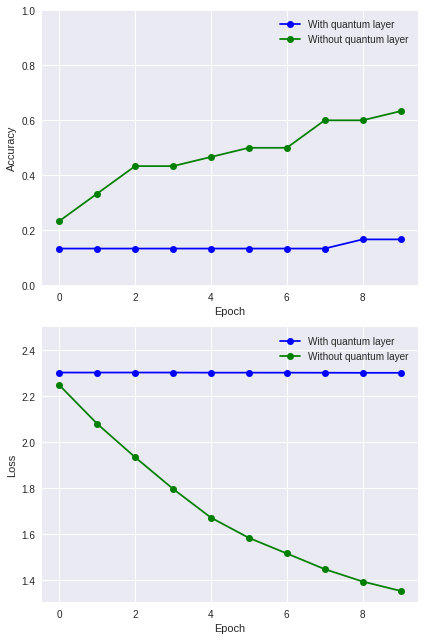

In [12]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h2> Repeat = 2 </h2>

In [20]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
    

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


ValueError: Attempt to convert a value (<tensorflow.python.keras.callbacks.History object at 0x7f50cdc9dd90>) with an unsupported type (<class 'tensorflow.python.keras.callbacks.History'>) to a Tensor.

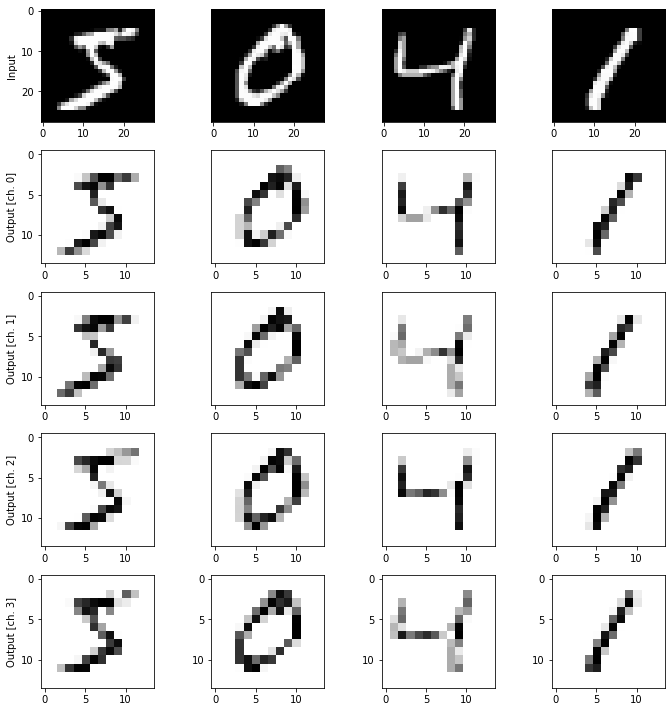

In [21]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [22]:
q_history, c_history = Train_model(100)


Epoch 1/100
13/13 - 0s - loss: 2.9721 - accuracy: 0.1400 - val_loss: 2.3821 - val_accuracy: 0.2333
Epoch 2/100
13/13 - 0s - loss: 2.4683 - accuracy: 0.1200 - val_loss: 2.2850 - val_accuracy: 0.1333
Epoch 3/100
13/13 - 0s - loss: 2.2978 - accuracy: 0.1800 - val_loss: 2.3318 - val_accuracy: 0.1333
Epoch 4/100
13/13 - 0s - loss: 2.0577 - accuracy: 0.2600 - val_loss: 2.0656 - val_accuracy: 0.1667
Epoch 5/100
13/13 - 0s - loss: 2.0429 - accuracy: 0.2000 - val_loss: 2.0574 - val_accuracy: 0.3333
Epoch 6/100
13/13 - 0s - loss: 2.0008 - accuracy: 0.3800 - val_loss: 2.0948 - val_accuracy: 0.2667
Epoch 7/100
13/13 - 0s - loss: 1.8033 - accuracy: 0.4000 - val_loss: 1.8969 - val_accuracy: 0.3333
Epoch 8/100
13/13 - 0s - loss: 1.7767 - accuracy: 0.4000 - val_loss: 1.9198 - val_accuracy: 0.3000
Epoch 9/100
13/13 - 0s - loss: 1.6454 - accuracy: 0.4600 - val_loss: 1.8177 - val_accuracy: 0.4333
Epoch 10/100
13/13 - 0s - loss: 1.4695 - accuracy: 0.6800 - val_loss: 1.8921 - val_accuracy: 0.3000
Epoch 11/

13/13 - 0s - loss: 0.1708 - accuracy: 1.0000 - val_loss: 1.1157 - val_accuracy: 0.6000
Epoch 84/100
13/13 - 0s - loss: 0.1722 - accuracy: 1.0000 - val_loss: 1.1168 - val_accuracy: 0.7000
Epoch 85/100
13/13 - 0s - loss: 0.1630 - accuracy: 1.0000 - val_loss: 1.1192 - val_accuracy: 0.6333
Epoch 86/100
13/13 - 0s - loss: 0.1694 - accuracy: 1.0000 - val_loss: 1.1022 - val_accuracy: 0.6333
Epoch 87/100
13/13 - 0s - loss: 0.1614 - accuracy: 1.0000 - val_loss: 1.1009 - val_accuracy: 0.6333
Epoch 88/100
13/13 - 0s - loss: 0.1582 - accuracy: 1.0000 - val_loss: 1.0809 - val_accuracy: 0.6333
Epoch 89/100
13/13 - 0s - loss: 0.1589 - accuracy: 1.0000 - val_loss: 1.0867 - val_accuracy: 0.6667
Epoch 90/100
13/13 - 0s - loss: 0.1476 - accuracy: 1.0000 - val_loss: 1.1018 - val_accuracy: 0.6333
Epoch 91/100
13/13 - 0s - loss: 0.1544 - accuracy: 1.0000 - val_loss: 1.0963 - val_accuracy: 0.6667
Epoch 92/100
13/13 - 0s - loss: 0.1465 - accuracy: 1.0000 - val_loss: 1.0960 - val_accuracy: 0.6000
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.9461 - val_accuracy: 0.7667
Epoch 67/100
13/13 - 0s - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.9475 - val_accuracy: 0.7667
Epoch 68/100
13/13 - 0s - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.9475 - val_accuracy: 0.7667
Epoch 69/100
13/13 - 0s - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.9485 - val_accuracy: 0.7667
Epoch 70/100
13/13 - 0s - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.9475 - val_accuracy: 0.7667
Epoch 71/100
13/13 - 0s - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.9480 - val_accuracy: 0.7667
Epoch 72/100
13/13 - 0s - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.9499 - val_accuracy: 0.7667
Epoch 73/100
13/13 - 0s - loss: 0.0311 - accuracy: 1.0000 - val_loss: 0.9477 - val_accuracy: 0.7667
Epoch 74/100
13/13 - 0s - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.9456 - val_accuracy: 0.7667
Epoch 75/100
13/13 - 0s - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.9450 - val_accuracy: 0.7667


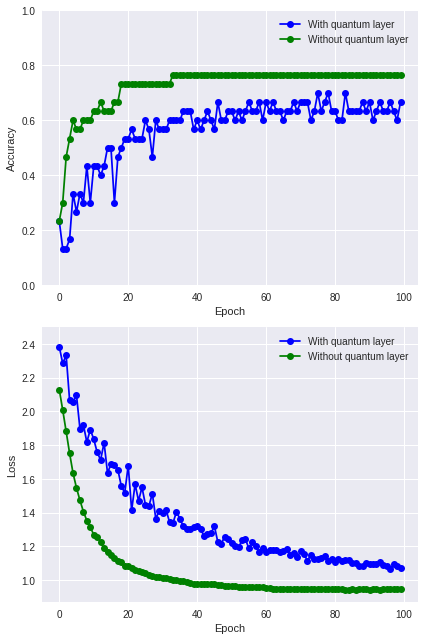

In [23]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 3 </h2>

In [ ]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_history, c_history = Train_model(100)

In [ ]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 4 </h2>

In [ ]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_history, c_history = Train_model(100)

In [ ]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 5<h2>

In [ ]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_history, c_history = Train_model(100)

In [ ]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 6</h2>

In [24]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(6) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
    

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


ValueError: Attempt to convert a value (<tensorflow.python.keras.callbacks.History object at 0x7f50b432f190>) with an unsupported type (<class 'tensorflow.python.keras.callbacks.History'>) to a Tensor.

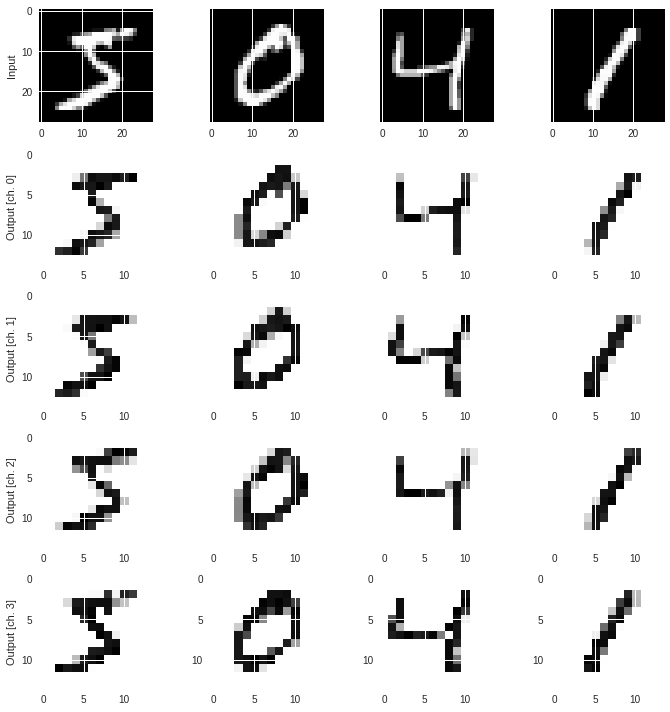

In [25]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [28]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 1s - loss: 3.0031 - accuracy: 0.1000 - val_loss: 2.3999 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 - 0s - loss: 2.3764 - accuracy: 0.1200 - val_loss: 2.2159 - val_accuracy: 0.1667
Epoch 3/100
13/13 - 0s - loss: 2.1215 - accuracy: 0.2800 - val_loss: 2.2409 - val_accuracy: 0.2000
Epoch 4/100
13/13 - 0s - loss: 1.7747 - accuracy: 0.3800 - val_loss: 1.9494 - val_accuracy: 0.3667
Epoch 5/100
13/13 - 0s - loss: 1.6997 - accuracy: 0.4600 - val_loss: 1.8468 - val_accuracy: 0.3667
Epoch 6/100
13/13 - 0s - loss: 1.5443 - accuracy: 0.6000 - val_loss: 1.8884 - val_accuracy: 0.4000
Epoch 7/100
13/13 - 0s - loss: 1.3145 - accuracy: 0.7400 - val_loss: 1.6431 - val_accuracy: 0.5333
Epoch 8/100
13/13 - 0s - loss: 1.1963 - accuracy: 0.7600 - val_loss: 1.6242 - val_accuracy: 0.5667
Epoch 9/100
13/13 - 0s - loss: 1.0657 - accuracy: 0.7600 - val_loss: 1.5351 - val_accuracy: 0.6333
Epoch 10/100
13/13 - 0s - loss: 0.9124 - accuracy: 0.9000 - val_loss: 1.5484 - val_accuracy: 0.5000
Epoch

Epoch 83/100
13/13 - 0s - loss: 0.0447 - accuracy: 1.0000 - val_loss: 0.9048 - val_accuracy: 0.6667
Epoch 84/100
13/13 - 0s - loss: 0.0431 - accuracy: 1.0000 - val_loss: 0.9076 - val_accuracy: 0.6667
Epoch 85/100
13/13 - 0s - loss: 0.0425 - accuracy: 1.0000 - val_loss: 0.9111 - val_accuracy: 0.6667
Epoch 86/100
13/13 - 0s - loss: 0.0420 - accuracy: 1.0000 - val_loss: 0.9214 - val_accuracy: 0.6667
Epoch 87/100
13/13 - 0s - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.9002 - val_accuracy: 0.7000
Epoch 88/100
13/13 - 0s - loss: 0.0397 - accuracy: 1.0000 - val_loss: 0.9014 - val_accuracy: 0.6667
Epoch 89/100
13/13 - 0s - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.9120 - val_accuracy: 0.6667
Epoch 90/100
13/13 - 0s - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.9072 - val_accuracy: 0.6667
Epoch 91/100
13/13 - 0s - loss: 0.0383 - accuracy: 1.0000 - val_loss: 0.9023 - val_accuracy: 0.7000
Epoch 92/100
13/13 - 0s - loss: 0.0379 - accuracy: 1.0000 - val_loss: 0.8934 - val_accuracy: 0.7333


13/13 - 0s - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.9648 - val_accuracy: 0.7667
Epoch 66/100
13/13 - 0s - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.9626 - val_accuracy: 0.7667
Epoch 67/100
13/13 - 0s - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.9645 - val_accuracy: 0.7667
Epoch 68/100
13/13 - 0s - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.9646 - val_accuracy: 0.7667
Epoch 69/100
13/13 - 0s - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.9665 - val_accuracy: 0.7667
Epoch 70/100
13/13 - 0s - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.9652 - val_accuracy: 0.7667
Epoch 71/100
13/13 - 0s - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.9660 - val_accuracy: 0.7667
Epoch 72/100
13/13 - 0s - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.9693 - val_accuracy: 0.7667
Epoch 73/100
13/13 - 0s - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.9672 - val_accuracy: 0.7667
Epoch 74/100
13/13 - 0s - loss: 0.0294 - accuracy: 1.0000 - val_loss: 0.9645 - val_accuracy: 0.7667
Epoch 75/100


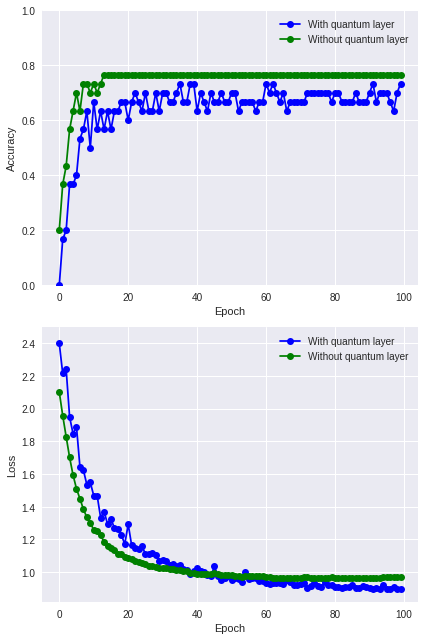

In [29]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 7 </h2> 

In [ ]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_history, c_history = Train_model(100)

In [ ]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 8</h2>

In [ ]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_history, c_history = Train_model(100)

In [ ]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 9</h2>

In [ ]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_history)
    QTestI.append(c_history)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_history, c_history = Train_model(100)

In [ ]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 10</h2>

In [ ]:
q_train_images, q_test_images = Process(10) # Repeat Process(repeat)

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
q_history, c_history = Train_model(50)

In [ ]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h1>Epochs</h1>